In [69]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#wordcloud
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

#ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

## Import data

In [2]:
raw_data = pd.read_csv("data\\spam.csv", encoding = 'latin1')

In [3]:
raw_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
raw_data['Unnamed: 2'].isnull().sum() / len(raw_data)

0.99102656137832013

In [5]:
raw_data['Unnamed: 3'].isnull().sum() / len(raw_data)

0.99784637473079685

In [6]:
raw_data['Unnamed: 4'].isnull().sum() / len(raw_data)

0.99892318736539842

The unamed columns are nearly all null. Will drop.

In [7]:
data = raw_data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis =1)
data = data.rename(columns={'v1':'label', 'v2':'text'})

In [8]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [10]:
# convert label to a numerical variable
data['label_num'] = data.label.map({'ham':0, 'spam':1})

## Visualisations

In [11]:
ham_words = ''
spam_words = ''
spam = data[data.label_num == 1]
ham = data[data.label_num ==0]

In [12]:
for val in spam.text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english')]
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in ham.text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [13]:
# Generate a word cloud image
spam_wordcloud = WordCloud(width=600, height=400).generate(spam_words)
ham_wordcloud = WordCloud(width=600, height=400).generate(ham_words)

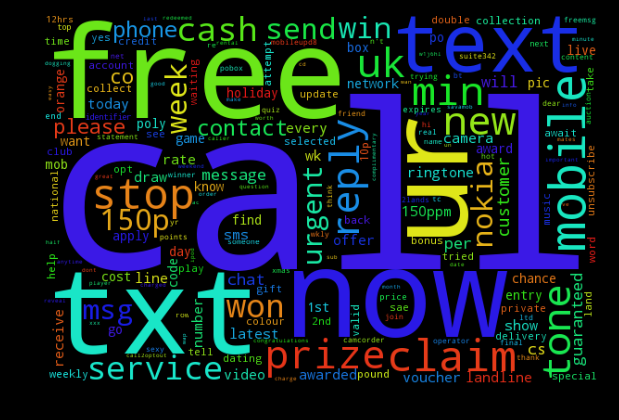

In [14]:
#Spam Word cloud
plt.figure(facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

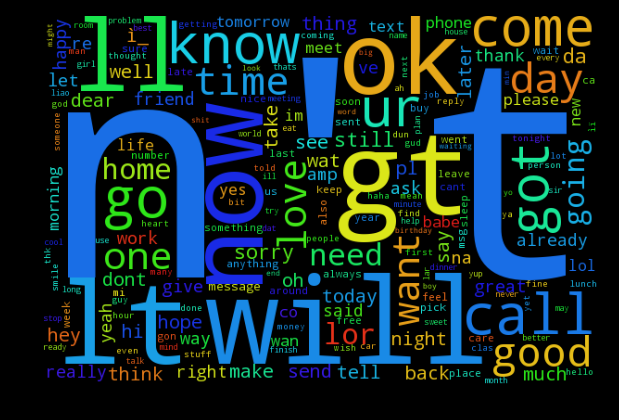

In [15]:
#Ham word cloud
plt.figure( facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [16]:
data['length'] = data['text'].apply(len)
data.head()

,label,text,label_num,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


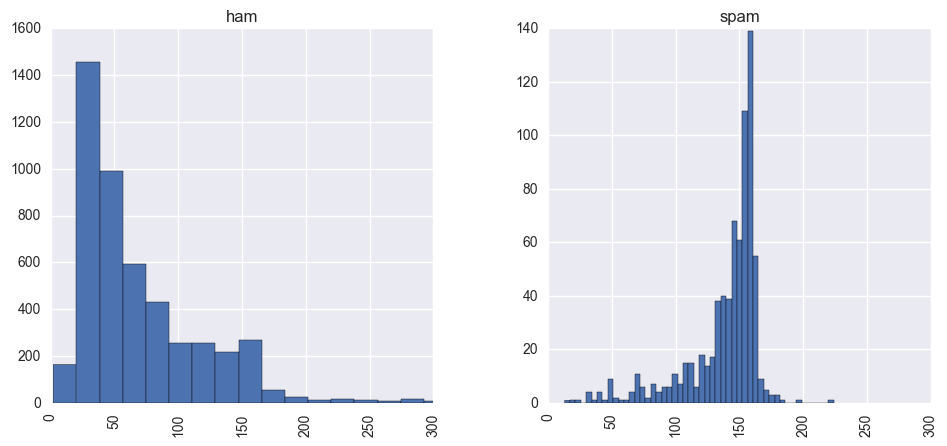

In [17]:
data.hist(column='length', by='label', bins=50,figsize=(11,5), sharex=True)
plt.xlim(0,300)
plt.show()

Spam messages tend to be longer

In [18]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=42)

In [19]:
train_set.shape, test_set.shape

((4457, 4), (1115, 4))

In [20]:
X_train = train_set['text']
y_train = train_set['label_num']
X_test = test_set['text']
y_test = test_set['label_num']

## Preprocessing

In [21]:
count_vect = CountVectorizer()

In [22]:
count_vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
X_train_df = count_vect.transform(X_train)

In [24]:
X_test_df = count_vect.transform(X_test)

In [25]:
lf_train = train_set['length'].as_matrix()

In [26]:
lf_test = test_set['length'].as_matrix()

In [27]:
X_train_df = np.hstack((X_train_df.todense(),lf_train[:, None]))

In [28]:
X_test_df = np.hstack((X_test_df.todense(),lf_test[:, None]))

## Models

### Naive Bayes

In [29]:
NB_multi = MultinomialNB()

In [30]:
NB_multi.fit(X_train_df, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
predict_NB = NB_multi.predict(X_test_df)

In [32]:
accuracy_score(y_test, predict_NB)

0.98116591928251118

In [33]:
NB_cv_score = cross_val_score(NB_multi, X_train_df, y_train, cv = 3)
NB_cv_score

array([ 0.9858681 ,  0.98115747,  0.97777778])

### Logistic Regression

In [34]:
log_reg = LogisticRegression()

In [35]:
log_reg.fit(X_train_df, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
predict_lr = log_reg.predict(X_test_df)

In [37]:
accuracy_score(y_test, predict_lr)

0.98295964125560542

In [38]:
lr_cv_score = cross_val_score(log_reg, X_train_df, y_train, cv = 3)
lr_cv_score

array([ 0.987214  ,  0.98183042,  0.98047138])

### KNN

In [39]:
knn = KNeighborsClassifier()

In [40]:
knn.fit(X_train_df, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [41]:
predict_knn = knn.predict(X_test_df)

In [42]:
accuracy_score(y_test, predict_knn)

0.91121076233183862

In [43]:
knn_cv_score = cross_val_score(knn, X_train_df, y_train, cv = 3)
knn_cv_score

array([ 0.92126514,  0.9192463 ,  0.8983165 ])

### SVM

In [44]:
svm = SVC()

In [45]:
svm.fit(X_train_df, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
predict_svm = svm.predict(X_test_df)

In [47]:
accuracy_score(y_test, predict_svm)

0.89865470852017937

In [48]:
svm_cv_score = cross_val_score(svm, X_train_df, y_train, cv = 3)
svm_cv_score

array([ 0.86608345,  0.89973082,  0.86868687])

### Random Forest

In [49]:
rf = RandomForestClassifier()

In [50]:
rf.fit(X_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [51]:
predict_rf = rf.predict(X_test_df)

In [52]:
accuracy_score(y_test, predict_rf)

0.9695067264573991

In [53]:
rf_cv_score = cross_val_score(rf, X_train_df, y_train, cv = 3)
rf_cv_score

array([ 0.96769852,  0.96702557,  0.96632997])

### Model Ranking

In [54]:
model_rank = pd.DataFrame(
    {'Model' : ['Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Naive Bayes']
        ,
     'CV Score': [np.mean(lr_cv_score),np.mean(rf_cv_score)
                  ,np.mean(knn_cv_score),np.mean(svm_cv_score), np.mean(NB_cv_score)]
     }    
)

In [55]:
model_rank.sort_values(by='CV Score', ascending = False)

,CV Score,Model
0,0.983172,Logistic Regression
4,0.981601,Naive Bayes
1,0.967018,Random Forest
2,0.912943,KNN
3,0.878167,SVM


Logistic Regression and Naive Bayes in the lead.Could Grid Search these.

### Model Evaluation

In [56]:
print(classification_report(y_test, predict_lr, target_names = ["Ham", "Spam"]))

             precision    recall  f1-score   support

        Ham       0.98      1.00      0.99       965
       Spam       0.99      0.88      0.93       150

avg / total       0.98      0.98      0.98      1115



In [57]:
print(classification_report(y_test, predict_NB, target_names = ["Ham", "Spam"]))

             precision    recall  f1-score   support

        Ham       0.98      1.00      0.99       965
       Spam       0.98      0.87      0.93       150

avg / total       0.98      0.98      0.98      1115



In [59]:
conf_mat_lr = confusion_matrix(y_test, predict_lr)
conf_mat_lr

array([[964,   1],
       [ 18, 132]])

In [58]:
conf_mat_NB = confusion_matrix(y_test, predict_NB)
conf_mat_NB

array([[963,   2],
       [ 19, 131]])

In [60]:
X_test[y_test < predict_lr]

3537    We are pleased to inform that your application...
Name: text, dtype: object

In [61]:
X_test[y_test > predict_lr]

4071    Loans for any purpose even if you have Bad Cre...
3979                                   ringtoneking 84484
751     You have an important customer service announc...
712                 08714712388 between 10am-7pm Cost 10p
1268    Can U get 2 phone NOW? I wanna chat 2 set up m...
730     Email AlertFrom: Jeri StewartSize: 2KBSubject:...
2662    Hello darling how are you today? I would love ...
3130    LookAtMe!: Thanks for your purchase of a video...
1468    Hi its LUCY Hubby at meetins all day Fri & I w...
2351    Download as many ringtones as u like no restri...
414     100 dating service cal;l 09064012103 box334sk38ch
3740                                        2/2 146tf150p
5120         PRIVATE! Your 2003 Account Statement for 078
4211    Missed call alert. These numbers called but le...
1874    Would you like to see my XXX pics they are so ...
2963    Do you ever notice that when you're driving, a...
4674    Hi babe its Chloe, how r u? I was smashed on s...
4293    Kit St

## Grid Searching

In [65]:
NB_params_grid = [
    {'alpha':[0,1,10]}
]

In [66]:
lr_params_grid = [
    {'penalty': ['l1', 'l2'], 'C':[0.1,1.0,10.0]}
]

In [67]:
rf_params_grid = [
{'n_estimators':[3,10,30,300], 'max_features':[2,4,6,8], 'max_depth':[None, 1, 2], 'bootstrap':[False,True]}
]

In [70]:
lr_grid_search = GridSearchCV(log_reg, lr_params_grid, cv = 3, scoring = 'accuracy')

In [71]:
lr_grid_search.fit(X_train_df, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [72]:
lr_grid_search.best_score_

0.98429436840924389

In [73]:
NB_grid_search = GridSearchCV(NB_multi, NB_params_grid, cv = 3, scoring = 'accuracy')

In [74]:
NB_grid_search.fit(X_train_df, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Program Files\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Program Files\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


GridSearchCV(cv=3, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0, 1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [75]:
NB_grid_search.best_score_

0.98160197442225716

In [76]:
rf_grid_search = GridSearchCV(rf, rf_params_grid, cv = 3, scoring = 'accuracy')

In [77]:
rf_grid_search.fit(X_train_df, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'bootstrap': [False, True], 'max_depth': [None, 1, 2], 'n_estimators': [3, 10, 30, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [78]:
rf_grid_search.best_score_

0.96499887816917207

In [79]:
final_model = lr_grid_search.best_estimator_

In [80]:
final_predictions = final_model.predict(X_test_df)

In [82]:
print(classification_report(y_test, final_predictions, target_names = ["Ham", "Spam"]))

             precision    recall  f1-score   support

        Ham       0.98      1.00      0.99       965
       Spam       0.99      0.89      0.94       150

avg / total       0.98      0.98      0.98      1115



In [83]:
conf_mat = confusion_matrix(y_test, final_predictions)
conf_mat

array([[963,   2],
       [ 16, 134]])